In [2]:
import os
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from matplotlib.dates import date2num
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter

In [26]:
n = pypsa.Network("networks/sample/solved/1993_181_90m_c1.25_Co2L0.0-1H.nc")

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [53]:
# # carrier_capital_costs = n.generators.drop_duplicates(subset='carrier')[['carrier', 'capital_cost']]
# # print(carrier_capital_costs)
# carrier_capital_costs2 = n.generators.groupby('carrier')['capital_cost'].max()
# print(carrier_capital_costs2)
# carrier_lifetime = n.generators.groupby('carrier')['lifetime'].max()
# print(carrier_lifetime)
# carrier_efficiency = n.generators.groupby('carrier')['efficiency'].max()

# n.generators.groupby('carrier')['capital_cost'].max()
n.generators.groupby('carrier')['lifetime'].min()
# n.storage_units.groupby('carrier')["capital_cost"].max()
# n.storage_units.groupby('carrier')["efficiency_dispatch"].min()

# n.lines["capital_cost"].max()
# n.lines["lifetime"].min()
# n.links["capital_cost"].max()
# n.links["efficiency"].min()

carrier
biomass       inf
nuclear       inf
offwind-ac    inf
offwind-dc    inf
onwind        inf
ror           inf
solar         inf
Name: lifetime, dtype: float64

In [22]:
n.carriers
n.generators.carrier
#n.generators_t.p[n.generators[n.generators.carrier.str.contains("solar")].index].sum().sum()
# Sum the power output for solar links
#n.links_t.p1[solar_links]
#n.links.carrier
#n.links_t.p1
#n.lines
#n.model definieren, rhs veränderliche sachen, lhs nicht
n.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,NaN,0.0
lc_limit,transmission_expansion_cost_limit,"AC, DC",<=,1.841591e+10,NaN,0.0


## Method 1: Global constraint

In [ ]:
# Calculate total load in the system across all snapshots
total_load = n.loads_t.p_set.sum().sum()

# Define the fraction of load that should be met by wind generation
wind_fraction = 0.6  # For example, 60% from wind

# Calculate total wind generation by summing the generation from onwind, offwind-dc, and offwind-ac
total_wind_generation = (n.generators_t.p.loc[:, n.generators.carrier.isin(['onwind', 'offwind-dc', 'offwind-ac'])].sum().sum())

# Add a global constraint to enforce that wind generation covers at least 60% of the total load
n.add("GlobalConstraint",
            "wind_generation_constraint",
            type="generation_share_per_carrier",
            carrier="wind",  # Aggregated wind generation
            sense=">=",
            constant=wind_fraction * total_load)

In [23]:
n.global_constraints.loc["renewable_share"] = [
    "renewable_share",  # type: The name/type of the constraint
    "solar",            # carrier_attribute: The carrier, in this case "solar"
    ">=",               # sense: The condition (greater than or equal to)
    0.50,               # constant: The value of the constraint (e.g., 50%)
    None,               # investment_period: Set to None if not applicable
    None                # mu: Dual variable (can be None if not used)
]

## Method 2: Custom global constraint

In [ ]:
# Assuming `network` is your PyPSA network and has already been defined

# Define the fraction of load that should be met by wind generation
wind_fraction = 0.6  # 60% of load should be met by wind

# Calculate total load in the system across all snapshots
total_load = network.loads_t.p_set.sum().sum()

# Function to add a custom constraint for wind generation share
def add_wind_generation_constraint(network, snapshots):
    # Calculate total wind generation by summing onwind, offwind-dc, and offwind-ac generators
    wind_generators = network.generators.index[network.generators.carrier.isin(['onwind', 'offwind-dc', 'offwind-ac'])]
    
    # Sum the generation for wind generators
    wind_generation = network.model['Generator-p'].loc[snapshots, wind_generators].sum().sum()

    # Add the constraint: wind generation >= wind_fraction * total load
    total_load_value = total_load  # Use the total load calculated earlier
    lhs = wind_generation
    rhs = wind_fraction * total_load_value
    
    # Add the constraint to the model
    network.model.add_constraints(lhs >= rhs, name="wind_generation_constraint")

# Solve the network with the custom constraint added via `extra_functionality`
network.lopf(network.snapshots, solver_name='gurobi', extra_functionality=add_wind_generation_constraint)

## Method 3: Limiting capacities

In [9]:
# Assuming `network` is your PyPSA network

# Define the desired fractions for wind and solar
wind_fraction = 0.6  # 60% of load should be met by wind
solar_fraction = 0.3  # 30% of load should be met by solar

# Calculate the total load over all snapshots
total_load = n.loads_t.p_set.sum().sum()

# Access the capacity factors from the network (generators_t.p_max_pu)
capacity_factors = n.generators_t.p_max_pu

# Filter the capacity factors for wind and solar generators
wind_generators = n.generators.index[n.generators.carrier.isin(['onwind', 'offwind-dc', 'offwind-ac'])]
solar_generators = n.generators.index[n.generators.carrier == 'solar']

# Calculate the average capacity factors for wind and solar generators over all snapshots
avg_wind_capacity_factor = capacity_factors[wind_generators].mean().mean()
avg_solar_capacity_factor = capacity_factors[solar_generators].mean().mean()

# Calculate the minimum installed capacity required for wind and solar
min_wind_capacity = (wind_fraction * total_load) / (avg_wind_capacity_factor * len(n.snapshots))
min_solar_capacity = (solar_fraction * total_load) / (avg_solar_capacity_factor * len(n.snapshots))

# Set p_nom_min for all wind generators
n.generators.loc[wind_generators, 'p_nom_min'] = min_wind_capacity / len(wind_generators)

# Set p_nom_min for all solar generators
n.generators.loc[solar_generators, 'p_nom_min'] = min_solar_capacity / len(solar_generators)

# Loop through the affected generators and adjust p_nom_max if needed
for gen in n.generators.index:
    if n.generators.loc[gen, 'p_nom_min'] > n.generators.loc[gen, 'p_nom_max']:
        # Set p_nom_max to infinity to allow expansion if p_nom_min is higher
        n.generators.loc[gen, 'p_nom_max'] = float('inf')

In [10]:
n.export_to_netcdf("networks/Outputs/Unsolved/2019_6030mix.nc")

INFO:pypsa.io:Exported network 2019_6030mix.nc has global_constraints, loads, carriers, storage_units, buses, lines, links, generators


<xarray.Dataset> Size: 387MB
Dimensions:                               (snapshots: 8760,
                                           investment_periods: 0,
                                           global_constraints_i: 2,
                                           loads_i: 90, loads_t_p_set_i: 90,
                                           loads_t_p_i: 90, carriers_i: 11,
                                           storage_units_i: 284,
                                           ...
                                           links_t_mu_upper_i: 47,
                                           generators_i: 692,
                                           generators_t_p_max_pu_i: 614,
                                           generators_t_p_i: 692,
                                           generators_t_mu_upper_i: 692,
                                           generators_t_mu_lower_i: 611)
Coordinates: (12/35)
  * snapshots                             (snapshots) int64 70kB 0 1 ... 8759
  * investment_periods                    (investment_periods) float64 0B 
  * global_constraints_i                  (global_constraints_i) object 16B '...
  * loads_i                               (loads_i) object 720B 'AL0 0' ... '...
  * loads_t_p_set_i                       (loads_t_p_set_i) object 720B 'AL0 ...
  * loads_t_p_i                           (loads_t_p_i) object 720B 'AL0 0' ....
    ...                                    ...
  * links_t_mu_upper_i                    (links_t_mu_upper_i) object 376B '1...
  * generators_i                          (generators_i) object 6kB 'BE0 0 bi...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 5kB ...
  * generators_t_p_i                      (generators_t_p_i) object 6kB 'BE0 ...
  * generators_t_mu_upper_i               (generators_t_mu_upper_i) object 6kB ...
  * generators_t_mu_lower_i               (generators_t_mu_lower_i) object 5kB ...
Data variables: (12/101)
    snapshots_snapshot                    (snapshots) datetime64[ns] 70kB 201...
    snapshots_objective                   (snapshots) float64 70kB 1.0 ... 1.0
    snapshots_generators                  (snapshots) float64 70kB 1.0 ... 1.0
    snapshots_stores                      (snapshots) float64 70kB 1.0 ... 1.0
    investment_periods_objective          (investment_periods) float64 0B 
    investment_periods_years              (investment_periods) float64 0B 
    ...                                    ...
    generators_control                    (generators_i) object 6kB '' '' ... ''
    generators_p_nom_opt                  (generators_i) float64 6kB 95.0 ......
    generators_t_p_max_pu                 (snapshots, generators_t_p_max_pu_i) float64 43MB ...
    generators_t_p                        (snapshots, generators_t_p_i) float64 48MB ...
    generators_t_mu_upper                 (snapshots, generators_t_mu_upper_i) float64 48MB ...
    generators_t_mu_lower                 (snapshots, generators_t_mu_lower_i) float64 43MB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           103720801403.40538
    network_objective_constant:  5716638764.469044
    network_pypsa_version:       0.22.0
    network_srid:                4326
    meta:                        {"version": "0.7.0", "tutorial": false, "log...

In [11]:
n2 = pypsa.Network("networks/Outputs/Unsolved/2019_6030mix.nc")

INFO:pypsa.io:Imported network 2019_6030mix.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [7]:
#n2.lopf(solver_name='gurobi')
n2.optimize(solver_name='gurobi')

Index(['BE1 1 offwind-ac', 'BE1 1 offwind-dc', 'BG1 1 offwind-ac',
       'BG1 1 offwind-dc', 'DE1 0 solar', 'DE1 13 offwind-ac',
       'DE1 14 offwind-ac', 'DE1 14 offwind-dc', 'DE1 20 offwind-ac',
       'DE1 20 offwind-dc',
       ...
       'RO1 1 offwind-dc', 'SE2 0 offwind-ac', 'SE2 0 offwind-dc',
       'SE2 0 solar', 'SE2 4 offwind-dc', 'SE2 4 solar', 'SE2 5 offwind-dc',
       'SE2 5 solar', 'SE2 6 solar', 'SI1 0 offwind-ac'],
      dtype='object', name='Generator', length=106)
Index(['BE1 1 offwind-ac', 'BE1 1 offwind-dc', 'BG1 1 offwind-ac',
       'BG1 1 offwind-dc', 'DE1 0 solar', 'DE1 13 offwind-ac',
       'DE1 14 offwind-ac', 'DE1 14 offwind-dc', 'DE1 20 offwind-ac',
       'DE1 20 offwind-dc',
       ...
       'RO1 1 offwind-dc', 'SE2 0 offwind-ac', 'SE2 0 offwind-dc',
       'SE2 0 solar', 'SE2 4 offwind-dc', 'SE2 4 solar', 'SE2 5 offwind-dc',
       'SE2 5 solar', 'SE2 6 solar', 'SI1 0 offwind-ac'],
      dtype='object', name='Generator', length=106)


KeyboardInterrupt: 

## TEST

In [ ]:
import pypsa
import pandas as pd
import glob
import os
import subprocess

# Parameters for the optimization solver
kwargs = {
    "threads": 0,
    "method": 2,  # barrier
    "crossover": 0,
    "BarConvTol": 1.e-5,
    "FeasibilityTol": 1.e-4,
    "OptimalityTol": 1.e-4,
    "Seed": 123,
    "AggFill": 0,
    "PreDual": 0,
    "GURO_PAR_BARDENSETHRESH": 200
}

# Step 2: Set up output directory for solved networks
output_directory = "networks/outputs/solved"
os.makedirs(output_directory, exist_ok=True)

# Step 3: Process each network file in the "networks/sample" folder
network_files = glob.glob("networks/sample/*.nc")

# Define the fraction of load that should be met by wind generation
wind_fraction = 0.6  # 60% of load should be met by wind

# Function to add a custom constraint for wind generation share
def add_wind_generation_constraint(network, snapshots):
    # Calculate total load across all snapshots
    total_load_value = network.loads_t.p_set.sum().sum()

    # Calculate total wind generation by summing onwind, offwind-dc, and offwind-ac generators
    wind_generators = network.generators.index[
        network.generators.carrier.isin(['onwind', 'offwind-dc', 'offwind-ac'])
    ]

    # Total wind generation across specified snapshots
    wind_generation = network.model['Generator-p'].loc[snapshots, wind_generators].sum(axis=1)

    # Add the constraint: wind generation >= wind_fraction * total load
    network.model.add_constraints(
        wind_generation >= wind_fraction * total_load_value,
        name="wind_generation_constraint"
    )

for network_file in network_files:
    print(f"Processing {network_file}...")

    # Load the network
    network = pypsa.Network(network_file)

    # Step 5: Solve only for the remaining snapshots with the custom constraint
    network.lopf(solver_name='gurobi', snapshots=network.snapshots[::96], extra_functionality=add_wind_generation_constraint, solver_options = kwargs)

    # Step 6: Export modified network
    output_filename = os.path.join(output_directory, os.path.basename(network_file).replace(".nc", "_MC_s.nc"))
    network.export_to_netcdf(output_filename)
    print(f"Solved and saved modified network to {output_filename}")


## PLOTTING

In [3]:
n = pypsa.Network("networks/outputs/solved/2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc")

INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [7]:
n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()

carrier
biomass       1.365851e+08
nuclear       6.482573e+08
offwind-ac    3.803371e+06
offwind-dc    3.945491e+06
onwind        1.428270e+09
ror           1.757474e+08
solar         9.021697e+08
dtype: float64

In [10]:
ls_filenames = ["1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc", "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc", "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc", "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc"]
all_gen = []
# Set the directory containing your .nc files
global_folder = 'networks/outputs/solved'
network_folder = 'networks/outputs/solved/'
type_mapping = {
    '_UC': 'Base Scenario',
    '_SC': 'Snapshot Changed',
    '_MC': 'Mix Changed',
    '_LT': 'Low Transmission',
    '_HT': 'High Transmission',
    '_LS': 'Low Storage',
    '_HS': 'High Storage'
}

for filename in ls_filenames:
    if filename.endswith('.nc'):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        summed_gen = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()
        bar_colors = n.carriers['color']
        
        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break

        # Store gen
        all_gen.append({
            'File': shortname,
            'Carrier': carrier,
            'Value': value,
            'Color': bar_colors.get(carrier, 'gray')
        })
        
        nrFiles += 1

# Convert accumulated costs to a DataFrame
all_gen_df = pd.DataFrame(all_gen)

# Pivot the data for stacked bar chart
pivoted_gen = all_gen_df.pivot_table(
    index='File',
    columns=['Carrier'],
    values='Value',
    fill_value=0
)

# Plot stacked bars
fig, ax = plt.subplots(figsize=((0.9*nrFiles), 6))
bar_width = 0.9
x = np.arange(len(pivoted_gen.index))  # One bar per file

# Store unique legend handles for capital costs
legend_handles = {}
# Iterate through carriers and cost types for stacking
y_offset = np.zeros(len(pivoted_gen.index))
for i, ((carrier), values) in enumerate(pivoted_gen.items()):
    # Determine color and hatching
    color = all_gen_df.loc[
        (all_gen_df['Carrier'] == carrier),
        'Color'
    ].iloc[0]
    
    # Plot bar segment
    ax.bar(x, values, bar_width, bottom=y_offset, label=f'{carrier} {cost_type}', color=color)
    y_offset += values  # Update offset for stacking

# Add labels and legend
#ax.set_title('Stacked Bar Chart of Carrier Costs by File with Custom Colors and Hatching')
ax.set_ylabel('Total System Generation')
ax.set_xticks(x)
ax.set_xticklabels(pivoted_gen.index, rotation=90)#, ha='right')


plt.tight_layout()
plt.show()
#plt.savefig(f'figures/Total_System_Gen.png')



INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


NameError: name 'carrier' is not defined

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


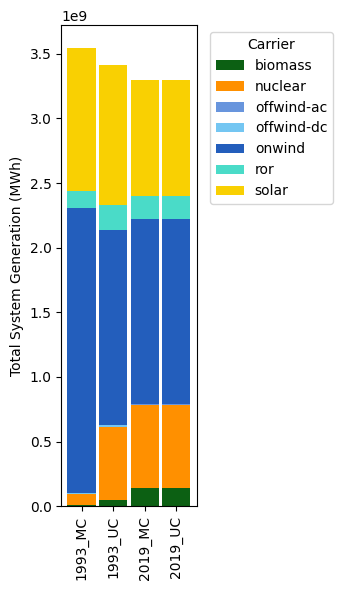

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Initialize data storage
all_gen = []

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Total generation per carrier
        total_generation = n.generators_t.p.multiply((n.snapshots[1] - n.snapshots[0]).seconds / 3600).groupby(n.generators.carrier, axis=1).sum().sum()

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]}{key}"
                break

        # Store the data
        for carrier, value in total_generation.items():
            color = n.carriers.loc[carrier, "color"] if carrier in n.carriers.index else "gray"
            all_gen.append({"File": shortname, "Carrier": carrier, "Value": value, "Color": color})

# Convert to DataFrame
all_gen_df = pd.DataFrame(all_gen)

# Pivot the data for plotting
pivoted_gen = all_gen_df.pivot_table(index="File", columns="Carrier", values="Value", fill_value=0)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(0.9 * len(ls_filenames), 6))
bar_width = 0.9
x = np.arange(len(pivoted_gen.index))  # X positions

# Stacking the bars
y_offset = np.zeros(len(pivoted_gen.index))
for carrier in pivoted_gen.columns:
    values = pivoted_gen[carrier]
    color = all_gen_df.loc[all_gen_df["Carrier"] == carrier, "Color"].iloc[0]
    ax.bar(x, values, bar_width, bottom=y_offset, label=carrier, color=color)
    y_offset += values

# Add labels, title, and legend
ax.set_ylabel("Total System Generation (MWh)")
ax.set_xticks(x)
ax.set_xticklabels(pivoted_gen.index, rotation=90)
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
#plt.savefig("figures/Total_System_Gen.png")
plt.show()


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


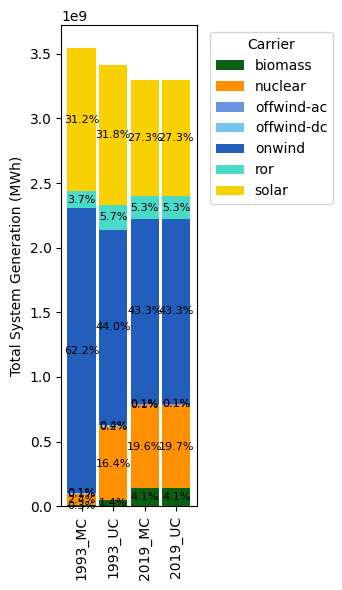

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Initialize data storage
all_gen = []

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Total generation per carrier
        total_generation = n.generators_t.p.multiply((n.snapshots[1] - n.snapshots[0]).seconds / 3600).groupby(n.generators.carrier, axis=1).sum().sum()

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]}{key}"
                break

        # Store the data
        for carrier, value in total_generation.items():
            color = n.carriers.loc[carrier, "color"] if carrier in n.carriers.index else "gray"
            all_gen.append({"File": shortname, "Carrier": carrier, "Value": value, "Color": color})

# Convert to DataFrame
all_gen_df = pd.DataFrame(all_gen)

# Pivot the data for plotting
pivoted_gen = all_gen_df.pivot_table(index="File", columns="Carrier", values="Value", fill_value=0)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(0.9 * len(ls_filenames), 6))
bar_width = 0.9
x = np.arange(len(pivoted_gen.index))  # X positions

# Stacking the bars
y_offset = np.zeros(len(pivoted_gen.index))
for carrier in pivoted_gen.columns:
    values = pivoted_gen[carrier]
    color = all_gen_df.loc[all_gen_df["Carrier"] == carrier, "Color"].iloc[0]
    ax.bar(x, values, bar_width, bottom=y_offset, label=carrier, color=color)
    
    # Add percentage annotations
    for i, (v, y) in enumerate(zip(values, y_offset)):
        total = pivoted_gen.sum(axis=1).iloc[i]
        if v > 0:  # Only annotate if the value is non-zero
            percentage = v / total * 100
            ax.text(
                x[i], y + v / 2,  # Position at the center of the bar segment
                f"{percentage:.1f}%",  # Format as percentage
                ha="center", va="center", fontsize=8, color="black"
            )
    y_offset += values

# Add labels, title, and legend
ax.set_ylabel("Total System Generation (MWh)")
ax.set_xticks(x)
ax.set_xticklabels(pivoted_gen.index, rotation=90)
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("figures/Total_System_Gen_Percentages.png")
plt.show()


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
/tmp/ipykernel_34964/2988908629.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  total_generation = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()
INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
/tmp/ipykernel_34964/2988908629.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  total_generation = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
/tmp/ipykernel_34964/2988908629.py:36: Futur

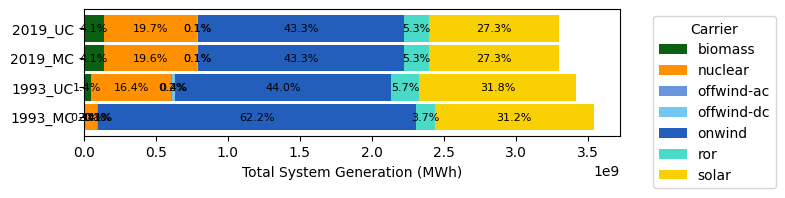

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Initialize data storage
all_gen = []

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Total generation per carrier
        total_generation = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]}{key}"
                break

        # Store the data
        for carrier, value in total_generation.items():
            color = n.carriers.loc[carrier, "color"] if carrier in n.carriers.index else "gray"
            all_gen.append({"File": shortname, "Carrier": carrier, "Value": value, "Color": color})

# Convert to DataFrame
all_gen_df = pd.DataFrame(all_gen)

# Pivot the data for plotting
pivoted_gen = all_gen_df.pivot_table(index="File", columns="Carrier", values="Value", fill_value=0)

# Plot horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(8, 0.5 * len(ls_filenames)))
bar_height = 0.9
y = np.arange(len(pivoted_gen.index))  # Y positions

# Stacking the bars horizontally
x_offset = np.zeros(len(pivoted_gen.index))
for carrier in pivoted_gen.columns:
    values = pivoted_gen[carrier]
    color = all_gen_df.loc[all_gen_df["Carrier"] == carrier, "Color"].iloc[0]
    ax.barh(y, values, bar_height, left=x_offset, label=carrier, color=color)
    
    # Add percentage annotations
    for i, (v, x) in enumerate(zip(values, x_offset)):
        total = pivoted_gen.sum(axis=1).iloc[i]
        if v > 0:  # Only annotate if the value is non-zero
            percentage = v / total * 100
            ax.text(
                x + v / 2, y[i],  # Position at the center of the bar segment
                f"{percentage:.1f}%",  # Format as percentage
                ha="center", va="center", fontsize=8, color="black"
            )
    x_offset += values

# Add labels, title, and legend
ax.set_xlabel("Total System Generation (MWh)")
ax.set_yticks(y)
ax.set_yticklabels(pivoted_gen.index)
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
#plt.savefig("figures/Total_System_Gen_Percentages_Horizontal.png")
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    # "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Initialize data storage
all_gen = []

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Total generation per carrier
        total_generation = n.generators_t.groupby(n.generators.carrier, axis=1).sum().sum()

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]}{key}"
                break

        # Create the pie chart
        ax.pie(
            total_generation,
            labels=n.generators["carrier"],
            autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
            colors=n.carriers["color"],
            startangle=90,
        )
        ax.set_title(shortname)

        plt.tight_layout()
        #plt.savefig("figures/Total_System_Gen_Pie_Charts.png")
        plt.show()


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


AttributeError: groupby

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


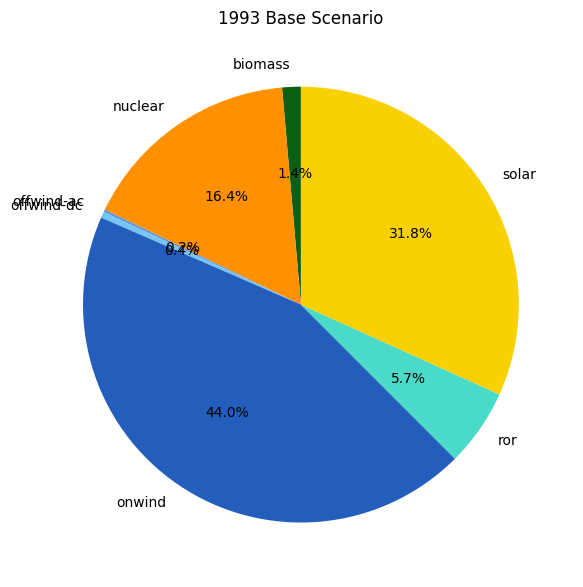

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    # "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        # Load the PyPSA network
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Calculate total generation per carrier
        total_generation = (
            n.generators_t.p.sum(axis=0)
            .groupby(n.generators.carrier)
            .sum()
        )

        # Extract type and name information for the title
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]} {scenario_type}"
                break

        # Generate the pie chart
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(
            total_generation,
            labels=total_generation.index,
            autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
            colors=[
                n.carriers.loc[carrier, "color"]
                if carrier in n.carriers.index else "gray"
                for carrier in total_generation.index
            ],
            startangle=90,
        )
        ax.set_title(shortname)

        plt.tight_layout()
        plt.show()


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


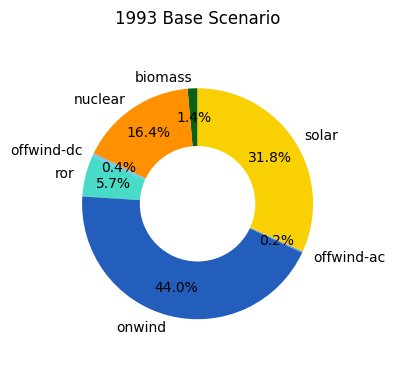

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


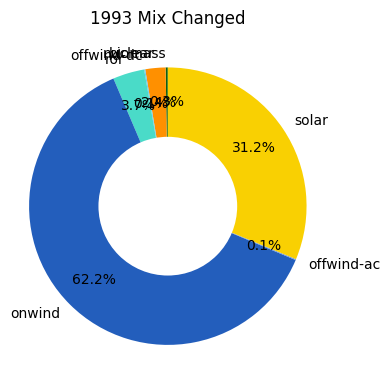

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc",
    # "2019_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Custom carrier order to separate offwind-ac and offwind-dc
carrier_order = ["biomass", "nuclear", "offwind-dc", "ror", "onwind", "offwind-ac", "solar"]

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        # Load the PyPSA network
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Calculate total generation per carrier
        total_generation = (
            n.generators_t.p.sum(axis=0)
            .groupby(n.generators.carrier)
            .sum()
        )

        # Reorder total_generation based on the custom carrier order
        total_generation = total_generation.reindex(carrier_order).dropna()

        # Extract type and name information for the title
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]} {scenario_type}"
                break

        # Generate the pie chart
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.pie(
            total_generation,
            labels=total_generation.index,
            autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
            pctdistance=0.75,
            colors=[
                n.carriers.loc[carrier, "color"]
                if carrier in n.carriers.index else "gray"
                for carrier in total_generation.index
            ],
            startangle=90,
            #radius=10
        )
        #draw circle
        centre_circle = plt.Circle((0,0),0.50,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        # Equal aspect ratio ensures that pie is drawn as a circle
        ax.axis('equal')  
        
        ax.set_title(shortname)

        plt.tight_layout()
        plt.show()


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


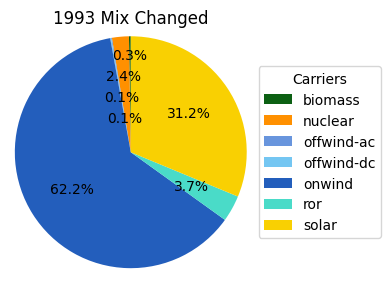

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# Define your file list and mappings
ls_filenames = [
    "1993_181_90m_c1.25_Co2L0.0-1H_MC_solved.nc",
]

network_folder = "networks/outputs/solved/"
type_mapping = {
    "_UC": "Base Scenario",
    "_SC": "Snapshot Changed",
    "_MC": "Mix Changed",
    "_LT": "Low Transmission",
    "_HT": "High Transmission",
    "_LS": "Low Storage",
    "_HS": "High Storage",
}

# Custom carrier order to separate offwind-ac and offwind-dc
#carrier_order = ["biomass", "nuclear", "ror", "onwind", "offwind-ac", "solar", "offwind-dc"]
label_distances = [1.4, 1.1, 0.8, 0.5, 1, 1, 1] #[1, 1, 1.2, 0.8, 1, 1, 1] #[1.4, 1.1, 0.8, 0.5, 1, 1, 1]

# Iterate over files
for filename in ls_filenames:
    if filename.endswith(".nc"):
        # Load the PyPSA network
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Calculate total generation per carrier
        total_generation = (
            n.generators_t.p.sum(axis=0)
            .groupby(n.generators.carrier)
            .sum()
        )

        # Reorder total_generation based on the custom carrier order
        #total_generation = total_generation.reindex(carrier_order).dropna()

        # Extract type and name information for the title
        for key, value in type_mapping.items():
            if key in filename:
                scenario_type = value
                shortname = f"{filename[:4]} {scenario_type}"
                break

        # Generate the pie chart
        fig, ax = plt.subplots(figsize=(4, 4))

        # Plot pie chart
        wedges, texts, autotexts = ax.pie(
            total_generation,
            autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
            colors=[
                n.carriers.loc[carrier, "color"]
                if carrier in n.carriers.index else "gray"
                for carrier in total_generation.index
            ],
            startangle=90,
            radius=1.2,
        )

        # Adjust the position of the percentage labels using the custom distances
        for i, autotext in enumerate(autotexts):
            x, y = autotext.get_position()
            distance = label_distances[i] if i < len(label_distances) else 1.0  # Default to 1.0 if out of range
            autotext.set_position((x * distance, y * distance))

        #Add a legend for the labels
        ax.legend(
            wedges,  # Use the pie wedges as handles
            total_generation.index,  # Labels for the legend
            title="Carriers",
            loc="center left",  # Adjust the location of the legend
            bbox_to_anchor=(1, 0.5),  # Place it to the right of the pie chart
        )

        ax.set_title(shortname)
        
        plt.tight_layout()
        #plt.show()
        plt.savefig(f'figures/mix_overview_{shortname}.pdf')
